In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from skimage import io, color, exposure, filters

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.19.0


In [21]:
# Set parameters here
INPUT_SIZE = 324
BATCH_SIZE = 64
SEED = 12345
np.random.seed(SEED)

from pathlib import Path
path = Path(os.getcwd())
trainpath = path / 'train'
testpath = path / 'test'
validpath = path / 'valid'

classes = ['BACTERIAL', 'NORMAL', 'VIRAL']
NUMCLASSES = len(classes)


In [23]:
def preprocess(img):
    img = img.astype('float32')
    if img.ndim == 3:
        img = np.mean(img, axis=2)

    img = img - np.min(img)
    maxv = np.max(img)
    if maxv > 0:
        img = img / maxv

    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / (std + 1e-7)
    return img


In [25]:
img = io.imread(trainpath+'/BACTERIAL/person1_bacteria_1.jpeg')
gray = preprocess(img)
gray.shape

(439, 712, 3)

In [27]:
print("Train path exists:", os.path.exists(trainpath))
print("Train path:", trainpath)

Train path exists: True
Train path: C:/Users/Gavela Maculuve/PycharmProjects/Ritcher/CS/Pneumonia2/train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9424759669896763..1.3152189966282808].


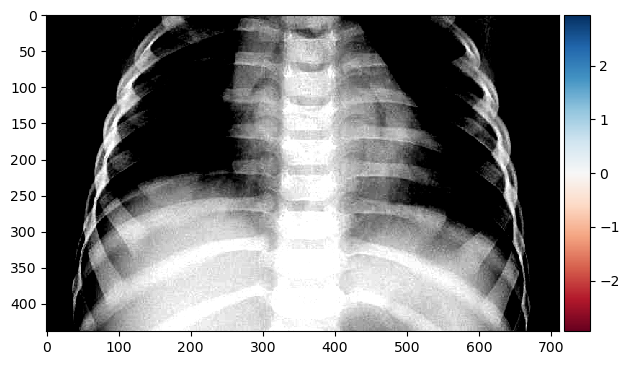

In [29]:
# gray = np.mean(img, axis=2)
io.imshow(gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9424759669896763..1.3152189966282808].


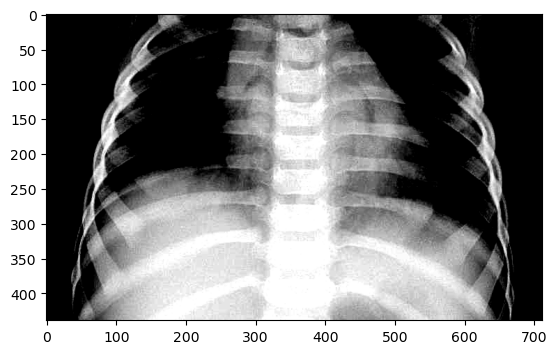

In [31]:
plt.imshow(gray, 'gray')

In [33]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess,
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess,
)


In [35]:
training_set = train_datagen.flow_from_directory(
    directory=trainpath,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED,
)

validation_set = valid_datagen.flow_from_directory(
    directory=validpath,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

test_set = valid_datagen.flow_from_directory(
    directory=testpath,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)


Found 3339 images belonging to 3 classes.
Found 833 images belonging to 3 classes.


In [ ]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_set.classes),
    y=training_set.classes,
)
class_weights = {i: w for i, w in enumerate(weights)}
class_weights


In [37]:
# Create a sequential model to add layers step by step
model = Sequential()

# Input layer that accepts grayscale images of shape
model.add(InputLayer(input_shape=[INPUT_SIZE, INPUT_SIZE, 1]))

model.add(Conv2D(filters=32, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=5, strides=1, padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.3))

# Global Average Pooling tends to generalize better than Flatten
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(NUMCLASSES, activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 162, 162, 32)   │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 81, 81, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 81, 81, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 81, 81, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 41, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,347 (8.64 MB)

 Trainable params: 2,265,347 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint('model-normalized-may-291-improved.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True),
]


In [39]:
# Training
epochs = 25
history = model.fit(
    training_set,
    epochs=epochs,
    validation_data=validation_set,
    class_weight=class_weights,
    callbacks=callbacks,
)
model.save_weights('model-normalized-may-291-improved-final.weights.h5')
print('Saved model to disk after', epochs, 'epochs.')


C:\Users\Gavela Maculuve\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4453 - loss: 1.1111 - val_accuracy: 0.4850 - val_loss: 1.0249
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5548 - loss: 0.9242 - val_accuracy: 0.6723 - val_loss: 0.6964
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6882 - loss: 0.6750 - val_accuracy: 0.6807 - val_loss: 0.6660
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7007 - loss: 0.6582 - val_accuracy: 0.7035 - val_loss: 0.6811
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7290 - loss: 0.6007 - val_accuracy: 0.6867 - val_loss: 0.7231
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7179 - loss: 0.5895 - val_accuracy: 0.7563 - val_loss: 0.6304
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7435 - loss: 0.5714 - val_accuracy: 0.7443 - val_loss: 0.5806
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7437 - loss: 0.5662 - val_accuracy: 0.7167 - val_loss

In [41]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

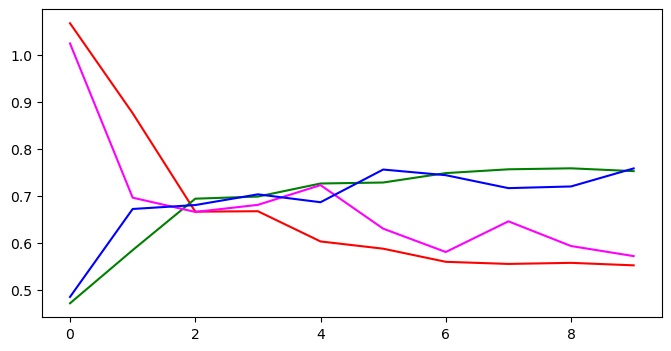

In [43]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Real class: BACTERIAL
Predictions:
BACTERIAL : 0.5606614
VIRAL : 0.4276677
NORMAL : 0.011670931


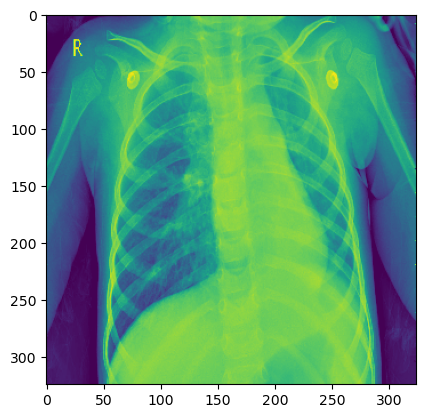

In [45]:
from skimage import io, transform, color, exposure
# Get random image
classnum = np.random.randint(NUMCLASSES)
folder = trainpath + '/' + classes[classnum]
filelist = os.listdir(folder)
i = np.random.randint(len(filelist))

while filelist[i].lower()=='thumbs.db':
    i = np.random.randint(len(filelist))

image_path = folder + '/' + filelist[i]
img = io.imread(image_path)

# Prepare image
img = cv2.resize(img,(INPUT_SIZE,INPUT_SIZE))
img = preprocess(img)


plt.imshow(img)
# plt.plot(exposure.histogram(img)[0])
img_tensor = np.expand_dims(img, axis=(0, -1))

# Print what the top predicted class is
# print(img_tensor)
preds = model.predict(img_tensor)
preds = preds.flatten()
# print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}
print('Real class:', classes[classnum])
print('Predictions:')
for i in range(3):
    if preds[order[i]] == 0:
        break
    else:
        print(reverse_class_labels[order[i]], ':', preds[order[i]])

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 759ms/step
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: VIRAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: NORMAL
Rea

array([404., 214., 215.])

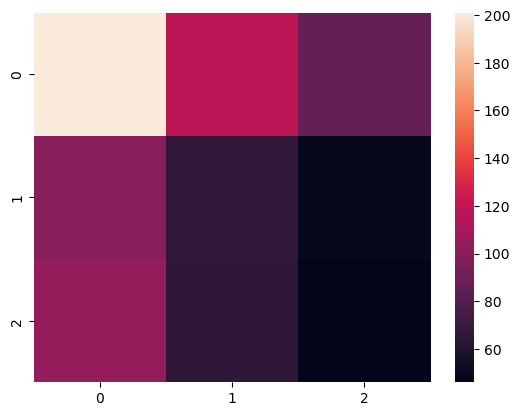

In [47]:
import seaborn as sn

testset = validation_set

predictions = model.predict(testset)

order = np.argsort(predictions)
conf = np.zeros([NUMCLASSES, NUMCLASSES])
count = 0

classcounts = np.zeros(NUMCLASSES)
for i in range(predictions.shape[0]):
    index = order[i,:]
    index = index[::-1]
    print('Real class:', reverse_class_labels[testset.labels[i]], end='\t')
    print('Prediction:',reverse_class_labels[index[0]])
    conf[testset.labels[i],index[0]] += 1
    classcounts[testset.labels[i]]+=1
    if testset.labels[i]==index[0]:
        count+=1
sn.heatmap(conf)
print(count)
classcounts    

<Axes: >

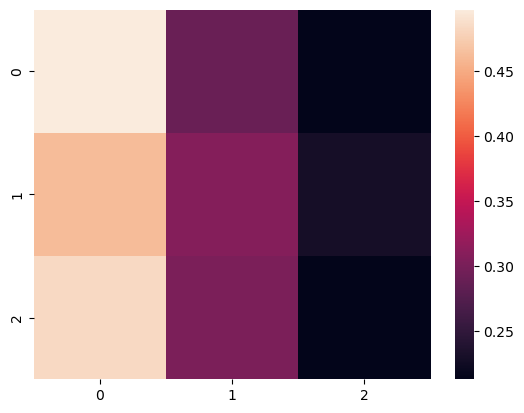

In [53]:
conf2 = np.copy(conf)
for i in range(conf2.shape[0]):
    conf2[i,:] /= classcounts[i]

sn.heatmap(conf2)

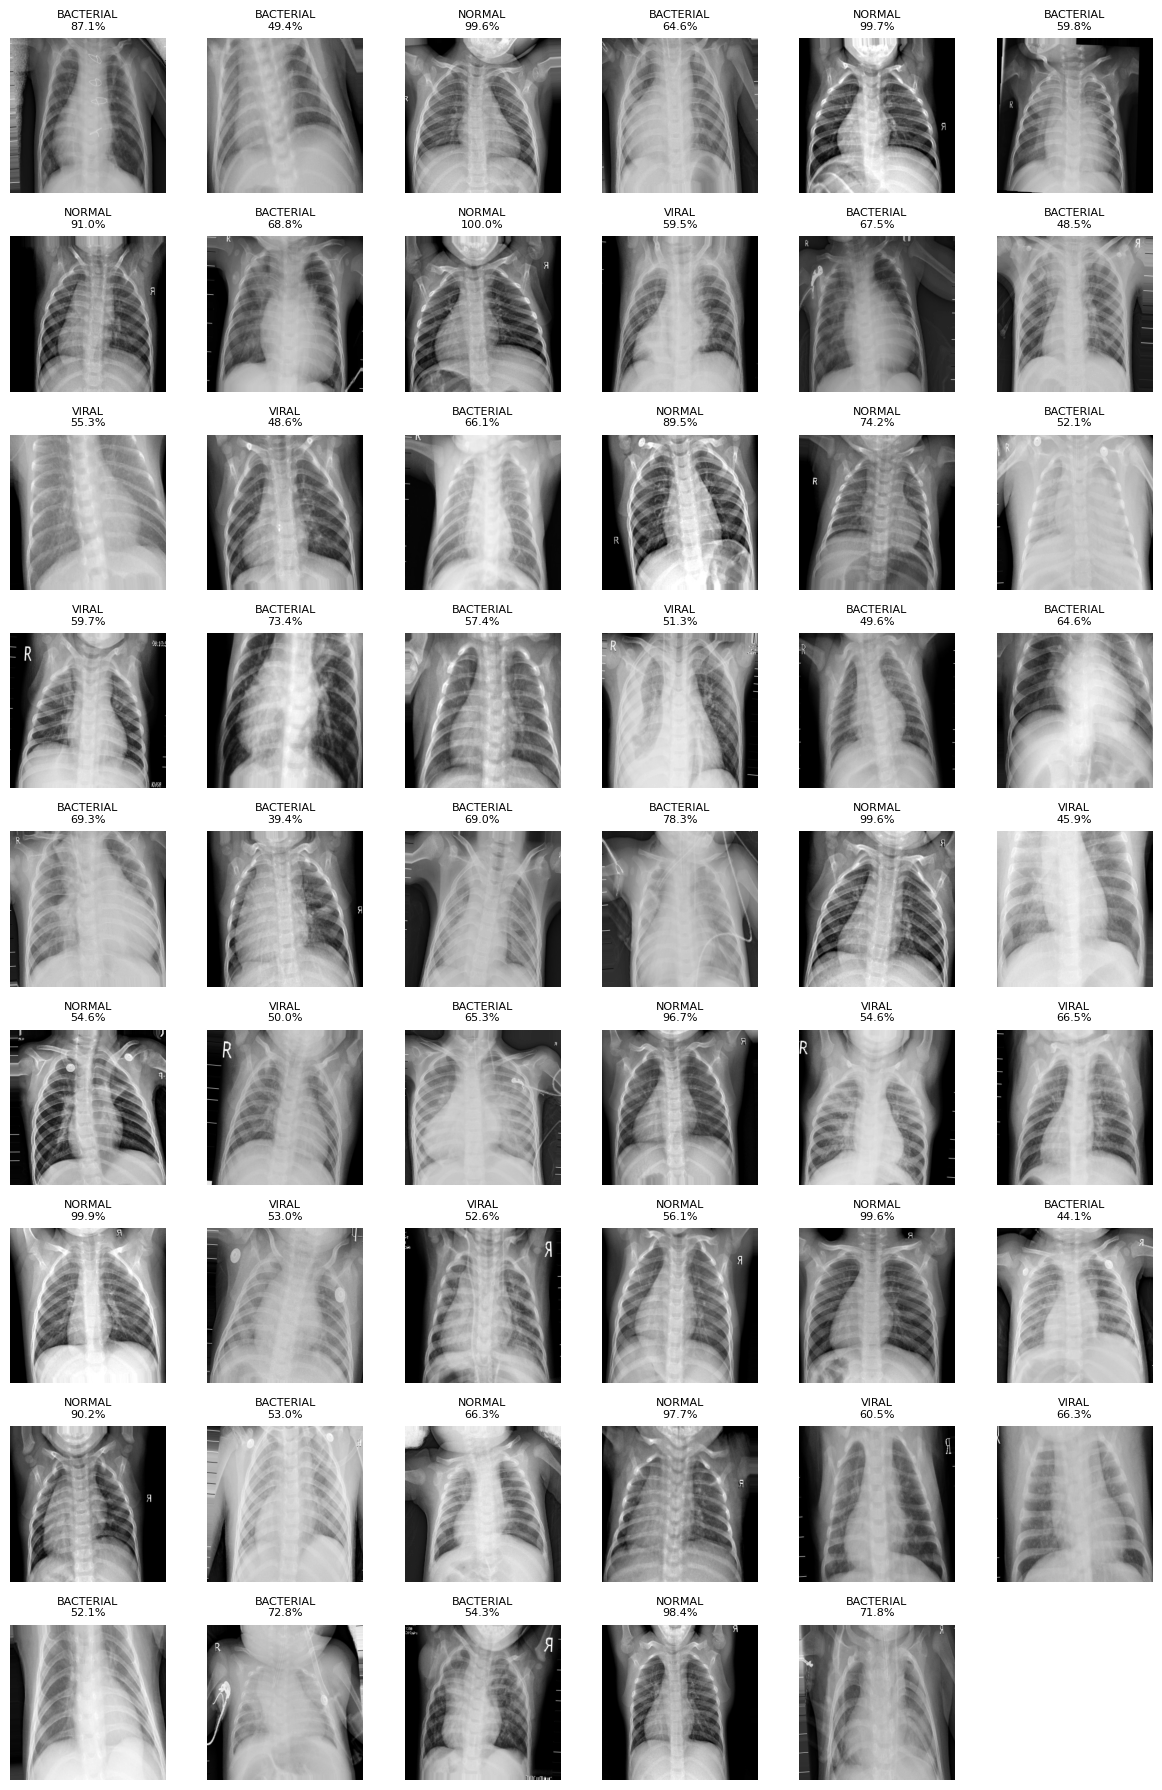

In [55]:
# Get one batch of training images and labels
images, labels = next(validation_set)

# Limit to N images to show
N = 53
fig = plt.figure(figsize=(12, 18))

for i in range(min(N, images.shape[0])):
    ax = fig.add_subplot(9, 6, i+1)

    # Prepare image for prediction
    img = images[i]
    img_input = img.reshape(1, INPUT_SIZE, INPUT_SIZE, 1)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_input, verbose=0)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    # Get predicted label name
    
    predicted_label = classes[predicted_class_index]

    # Show image with predicted label
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"{predicted_label}\n{confidence:.1f}%", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# --- Transfer Learning (EfficientNetB0) ---
# Recommended for best accuracy on this dataset.


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

TL_INPUT_SIZE = 224
TL_BATCH_SIZE = 32


In [ ]:
def preprocess_rgb(img):
    # Ensure 3-channel RGB then use EfficientNet preprocess
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    elif img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    img = preprocess_input(img.astype('float32'))
    return img


In [ ]:
tl_train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_rgb,
)

tl_valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_rgb,
)

# Generators for transfer learning (RGB)
tl_train = tl_train_datagen.flow_from_directory(
    directory=trainpath,
    target_size=(TL_INPUT_SIZE, TL_INPUT_SIZE),
    color_mode='rgb',
    batch_size=TL_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED,
)

tl_valid = tl_valid_datagen.flow_from_directory(
    directory=validpath,
    target_size=(TL_INPUT_SIZE, TL_INPUT_SIZE),
    color_mode='rgb',
    batch_size=TL_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

tl_test = tl_valid_datagen.flow_from_directory(
    directory=testpath,
    target_size=(TL_INPUT_SIZE, TL_INPUT_SIZE),
    color_mode='rgb',
    batch_size=TL_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)


In [ ]:
# Build EfficientNetB0 model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(TL_INPUT_SIZE, TL_INPUT_SIZE, 3),
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(TL_INPUT_SIZE, TL_INPUT_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUMCLASSES, activation='softmax')(x)

tl_model = tf.keras.Model(inputs, outputs)

tl_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
)

tl_model.summary()


In [ ]:
# Train head
head_epochs = 8
history_tl_head = tl_model.fit(
    tl_train,
    epochs=head_epochs,
    validation_data=tl_valid,
    class_weight=class_weights,
    callbacks=callbacks,
)


In [ ]:
# Fine-tune last layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

tl_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
)

ft_epochs = 12
history_tl_ft = tl_model.fit(
    tl_train,
    epochs=ft_epochs,
    validation_data=tl_valid,
    class_weight=class_weights,
    callbacks=callbacks,
)

tl_model.save_weights('model-efficientnetb0-improved.weights.h5')


In [ ]:
# Evaluate on test set
loss, acc, auc = tl_model.evaluate(tl_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {acc:.4f}")
print(f"Test AUC: {auc:.4f}")


In [ ]:
# Confusion matrix + classification report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt

# Predictions
pred_probs = tl_model.predict(tl_test, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = tl_test.classes
class_names = list(tl_test.class_indices.keys())

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,5))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNetB0 - Confusion Matrix')
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))


In [ ]:
# TensorBoard logging
from datetime import datetime
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
# Add TensorBoard to callbacks for TL runs
callbacks_tl = callbacks + [tb_callback]


In [ ]:
# Show misclassified test examples
import random

# Ensure predictions exist
pred_probs = tl_model.predict(tl_test, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = tl_test.classes
class_names = list(tl_test.class_indices.keys())

mis_idx = np.where(pred_labels != true_labels)[0]
print(f"Misclassified: {len(mis_idx)} / {len(true_labels)}")

if len(mis_idx) > 0:
    # Show up to 12 misclassified images
    sample = random.sample(list(mis_idx), k=min(12, len(mis_idx)))
    plt.figure(figsize=(12, 9))
    for i, idx in enumerate(sample, 1):
        img, _ = tl_test[idx]
        # tl_test returns batches; pick first element
        img = img[0]
        true_name = class_names[true_labels[idx]]
        pred_name = class_names[pred_labels[idx]]
        conf = np.max(pred_probs[idx])
        ax = plt.subplot(3, 4, i)
        plt.imshow(img.astype('uint8'))
        plt.title(f"T:{true_name} / P:{pred_name}
{conf:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
